In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import numpy as np
import sys
sys.path.append('../src/fnc')

import LMPC
import SysModel
from Track import Map
import Utilities
import pwa_cluster as pwac

import matplotlib.pyplot as plt

In [42]:
trackMap = Map(0.8) 
dt = 0.1
n = 6; d = 2
state_names = ['vx', 'vy', 'wz', 'epsi', 's', 'ey']

n_data = 500

In [43]:
def generate_random_input():
    # x = [vx, vy, wz, epsi, s, ey]
    # u = [delta, a]
    x = np.random.uniform(size=[n]) * np.array([3, 1, 1, 1, trackMap.TrackLength, 2*0.8]) + np.array([0, 0, 0, 0, 0, -0.8])
    u = np.random.uniform(size=[d]) * np.array([1, 2]) + np.array([-0.5, -1])
    return x, u

def get_z_y_pair():
    x, u = generate_random_input()
    x_glob = trackMap.get_global_state(x)
    x_next, x_glob_next = SysModel._DynModel(x, x_glob, u, dt, trackMap.PointAndTangent)
    return np.hstack([x,u]), x_next


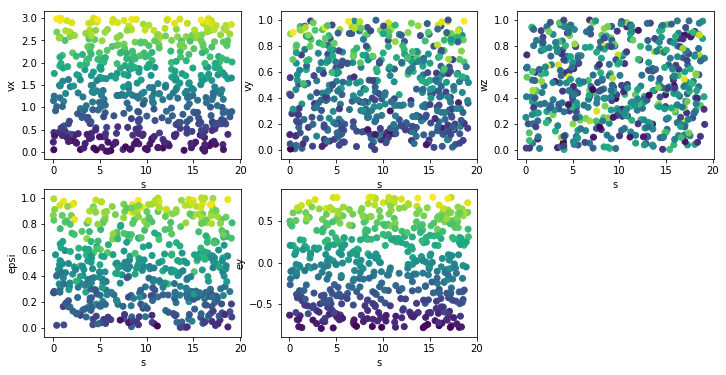

In [44]:
zs = []; ys = []
for i in range(n_data):
    z, y = get_z_y_pair()
    zs.append(z); ys.append(y)

zs = np.array(zs)
ys = np.array(ys)
    
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=[ys[:,ind]])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [16]:
best_clustering = pwac.ClusterPWA.from_num_clusters(zs, ys, 4)

In [17]:
best_clustering.fit_clusters()

In [45]:
nc_list = [2]
best_clustering, ind_perm = pwac.select_nc_cross_validation(nc_list, zs, ys, verbose=True, z_cutoff=n)


===================== Fitting model with Nc= 2 ====================
assigning datapoints to clusters
updating models
centroid movement 3.51529266769
assigning datapoints to clusters
updating models
centroid movement 0.112168113088
assigning datapoints to clusters
updating models
centroid movement 0.0383144787299
assigning datapoints to clusters
updating models
centroid movement 0.0
done
avg train error: 0.026737714746
avg test error: [ 0.01194783  0.01603867  0.28105854  0.02028258  0.01653286  0.07197841
  0.02123104  0.05961848  0.02879136  0.04837893  0.01916308  0.01569742
  0.11350441  0.0239928   0.12830933  0.42158781  0.01317462  0.01326344
  0.01621492  0.02490392  0.09080353  0.02161989  0.9837049   0.03857666
  0.0305815   0.07766091  0.023146    0.01272032  0.01980614  0.01234776
  0.02070958  0.01258471  0.0283761   0.08679749  0.02936433  0.07869639
  0.02511587  0.05465027  0.01941523  0.02092989  0.01347541  0.01595197
  0.01245196  0.21079391  0.01710791  0.02332897  0

../src/fnc/pwa_cluster.py:381: RuntimeWarning: divide by zero encountered in true_divide
  test_errors = np.abs(clustering.get_prediction_errors(new_zs=zs_test, new_ys=ys_test))


In [46]:
best_clustering.Nc

2

In [47]:
best_clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 8000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 514, constraints m = 1000
Cones:	linear vars: 1000
Setup time: 1.58e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.77e-01  3.30e-01  3.84e-01 -3.58e-01  2.64e-01  1.40e-16  5.38e-02 
   100| 5.41e-02  6.58e-03  6.16e-03  8.46e-03  1.48e-02  1.98e-17  7.79e-02 
   200| 6.39e-02  7.87e-03  9.96e-03  5.83e-03  1.60e-02  2.80e-17  1.02e-01 
   300| 2.30e-04  3.57e-06  8.14e-07 -8.14e-07 -0.00e+00  3

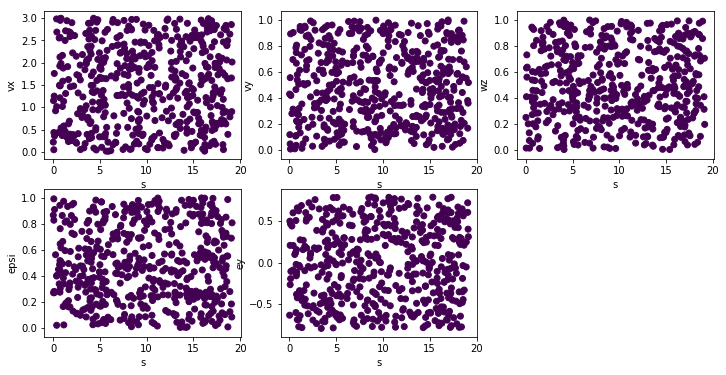

In [55]:
data = np.load('../src/cluster_labels.npz')
# looks like everything is in the same region here....

labels = []
for z,y in zip(zs,ys):
    dot_pdt = [w.T.dot(np.hstack([z[0:n], [1]])) for w in data['region_fns']]
    labels.append(np.argmax(dot_pdt))

plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']

In [52]:
data.keys()

['region_fns', 'thetas', 'labels']

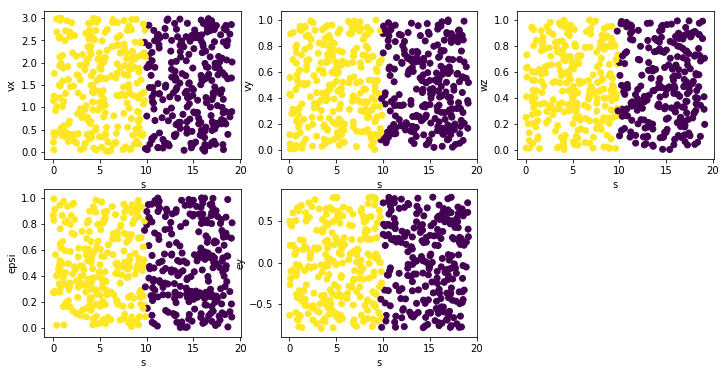

In [48]:
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=best_clustering.cluster_labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

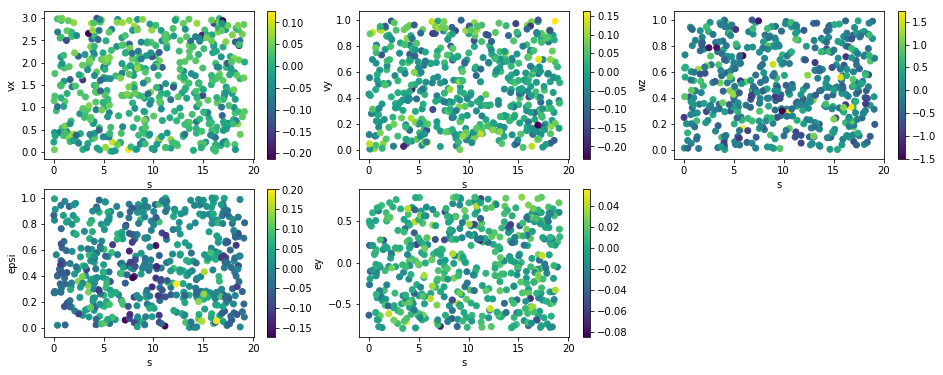

In [49]:
yhats = []
for z,y in zip(best_clustering.zs, best_clustering.ys):
    yhats.append(best_clustering.get_prediction(z))
yhats = np.array(yhats)

plt.figure(figsize=[16,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=(best_clustering.ys[:,ind]-yhats[:,ind]))
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind]); plt.colorbar()

In [50]:
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']
np.savez('pwa_model_'+str(best_clustering.Nc), labels=best_clustering.cluster_labels, region_fns=best_clustering.region_fns, 
         thetas=best_clustering.thetas, zs=best_clustering.zs, ys=best_clustering.ys)

In [8]:
print(x_next)
print(x_glob_next)

[  0.40271081  -0.0565205   -0.51047363   0.06231556  11.55229491
  -0.59633254]
[ 0.40362651 -0.05722567 -0.51032248  3.10423143 -2.42395266 -3.05482882]


In [ ]:
[[ 0.98  0.03 -0.01  0.01  0.    0.     nan  0.07  0.1    nan -0.01]
 [ 0.06  0.22 -0.02 -0.03  0.    0.     nan  0.23  0.02   nan -0.05]
 [ 0.05  0.28  0.01 -0.02  0.    0.04   nan  2.73  0.04   nan -0.07]
 [ 0.03  0.01  0.02  1.01  0.   -0.02   nan  0.18  0.     nan  0.  ]
 [ 0.08 -0.    0.   -0.06  1.   -0.03   nan -0.01 -0.     nan  0.02]
 [ 0.05  0.03 -0.    0.08  0.    1.     nan  0.03  0.01   nan -0.04]]
[[ 0.98  0.02 -0.01 -0.   -0.   -0.     nan  0.15  0.1    nan  0.  ]
 [ 0.06  0.24 -0.04 -0.03 -0.    0.01   nan  0.18  0.01   nan -0.05]
 [ 0.07  0.1   0.07  0.07  0.01  0.08   nan  3.32  0.01   nan -0.04]
 [ 0.03  0.01  0.03  1.    0.   -0.02   nan  0.2   0.     nan  0.  ]
 [ 0.09 -0.01  0.01 -0.06  1.   -0.04   nan -0.01  0.     nan  0.02]
 [ 0.05  0.04 -0.    0.08 -0.    1.     nan  0.03  0.     nan -0.04]]


In [ ]:
[[ 0.95  0.53 -0.05 -0.01 -0.    0.03   nan  0.01  0.09   nan  0.01]
 [-0.01 -0.    0.01 -0.    0.   -0.01   nan  0.25 -0.     nan  0.01]
 [-0.19 -0.94  0.15 -0.02  0.   -0.08   nan  2.41 -0.03   nan  0.12]
 [ 0.02  0.01  0.02  1.09 -0.    0.02   nan  0.18  0.01   nan  0.  ]
 [ 0.09 -0.02  0.   -0.01  1.   -0.02   nan -0.    0.     nan  0.  ]
 [ 0.01 -0.03  0.01  0.07  0.    1.     nan  0.02  0.     nan -0.  ]]
[[ 0.83  0.39 -0.05  0.02 -0.   -0.05   nan  0.04  0.09   nan  0.12]
 [-0.01 -0.12  0.02  0.   -0.   -0.     nan  0.25 -0.     nan  0.01]
 [-0.21 -2.13  0.27  0.03 -0.   -0.04   nan  2.43 -0.     nan  0.14]
 [ 0.01 -0.22  0.05  1.1  -0.    0.01   nan  0.18 -0.     nan  0.01]
 [ 0.08  0.03 -0.   -0.    1.   -0.03   nan  0.    0.     nan  0.01]
 [ 0.    0.01  0.    0.07 -0.    1.     nan  0.02  0.     nan -0.  ]]
